In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!mkdir dataset
#!unrar e '/content/drive/MyDrive/Dataset/crackles_dataset/audio_dataset.rar' -d '/content/dataset'

In [ ]:
!mkdir processed_audio_files
!unzip '/content/drive/MyDrive/Dataset/crackles_dataset/processed_audio_1.zip' -d '/content/processed_audio_files'

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed_audio_files/content/processed_audio_1/224_1b1_Tc_sc_Meditron_6.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/145_2b2_Lr_mc_AKGC417L_1.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/186_3b3_Pr_mc_AKGC417L_4.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/149_1b1_Al_sc_Meditron_0.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/184_1b1_Ar_sc_Meditron_7.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/130_1p4_Tc_mc_AKGC417L_0.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/130_1p4_Ar_mc_AKGC417L_0.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/186_2b2_Lr_mc_AKGC417L_4.wav  
  inflating: /content/processed_audio_files/content/processed_audio_1/218_1b1_Al_sc_Meditron_4.wav  
  inflating: /content/processed_audio_fi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

import librosa as lb
import librosa.display
import soundfile as sf
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.tree import DecisionTreeClassifier

### Dataset

In [ ]:
### Audio data format txt --> List
folder = '/content/dataset'
filename_list=[]
for file in os.listdir(folder):
    if file.endswith('.txt'):
        filename_list.append(file.split('.')[0])
filename_list = sorted(filename_list)
filename_list[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

In [ ]:
# Mengabungkan data txt dengan filename_list
def create_data_txt(folder, filename_list):
    audio_df = []
    #length = len(os.listdir(path))
    #index = range(length)
    
    for file in filename_list:
        loc = path+file+'.txt'
        data = pd.read_csv(loc, sep='\t', names=['start','end','crackles','weezels'])
        name_data = file.split('_')
        data['Id'] = name_data[0]
        data['filename'] = file

        audio_df.append(data)

    audio_df = pd.concat(audio_df)
    #audio_df.reset_index()
    #audio_df = audio_df.rename_axis('ID')
    return audio_df

path = '/content/dataset/'
audio_df = create_data_txt(path ,filename_list)
#audio_df.index = np.arange(1,len(audio_df)+1)
audio_df.reset_index(drop=True, inplace=True)

# Change Id dtypes into int
audio_df.Id = audio_df.Id.astype('int64')
audio_df.tail()

,start,end,crackles,weezels,Id,filename
6893,11.721,13.693,1,0,226,226_1b1_Pl_sc_LittC2SE
6894,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE
6895,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE
6896,17.493,19.436,1,0,226,226_1b1_Pl_sc_LittC2SE
6897,19.436,19.979,0,0,226,226_1b1_Pl_sc_LittC2SE


### Preprocessing

In [ ]:
# Seperate data normal and crackles
crackles = []
normal = []
for idx, col in audio_df.iterrows():
    if (col['crackles']==0) and (col['weezels']==0):
        normal.append(col)
    elif (col['crackles']==1) and (col['weezels']==0):
        crackles.append(col)
    else:
        pass

In [ ]:
# Normal dataframe
normal_df = pd.DataFrame(normal)
normal_df.reset_index(drop=True, inplace=True)
normal_df.tail()

,start,end,crackles,weezels,Id,filename
3637,1.207,3.550,0,0,226,226_1b1_Pl_sc_LittC2SE
3638,7.879,9.836,0,0,226,226_1b1_Pl_sc_LittC2SE
3639,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE
3640,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE
3641,19.436,19.979,0,0,226,226_1b1_Pl_sc_LittC2SE


In [ ]:
# Crackles dataframe
crackles_df = pd.DataFrame(crackles)
crackles_df.reset_index(drop=True, inplace=True)
crackles_df.tail()

,start,end,crackles,weezels,Id,filename
1859,3.550,5.750,1,0,226,226_1b1_Pl_sc_LittC2SE
1860,5.750,7.879,1,0,226,226_1b1_Pl_sc_LittC2SE
1861,9.836,11.721,1,0,226,226_1b1_Pl_sc_LittC2SE
1862,11.721,13.693,1,0,226,226_1b1_Pl_sc_LittC2SE
1863,17.493,19.436,1,0,226,226_1b1_Pl_sc_LittC2SE


In [ ]:
# Concatenate crackles_df with normal_df
data_df = crackles_df.append(normal_df)

# Drop weezels column
data_df.drop('weezels', axis=1, inplace=True)
data_df.reset_index(drop=True, inplace=True)
data_df.tail()

,start,end,crackles,Id,filename
5501,1.207,3.550,0,226,226_1b1_Pl_sc_LittC2SE
5502,7.879,9.836,0,226,226_1b1_Pl_sc_LittC2SE
5503,13.693,15.536,0,226,226_1b1_Pl_sc_LittC2SE
5504,15.536,17.493,0,226,226_1b1_Pl_sc_LittC2SE
5505,19.436,19.979,0,226,226_1b1_Pl_sc_LittC2SE


In [ ]:
# Add crackles sound duration on dataframe
data_df['duration'] = (data_df.end-data_df.start)
data_df.head()

,start,end,crackles,Id,filename,duration
0,8.8287,10.396,1,104,104_1b1_Ll_sc_Litt3200,1.5673
1,0.0360,2.164,1,106,106_2b1_Pl_mc_LittC2SE,2.1280
2,2.1640,4.621,1,106,106_2b1_Pl_mc_LittC2SE,2.4570
3,7.1790,9.636,1,106,106_2b1_Pl_mc_LittC2SE,2.4570
4,9.6360,12.007,1,106,106_2b1_Pl_mc_LittC2SE,2.3710


Mean : 2.667
Median : 2.512


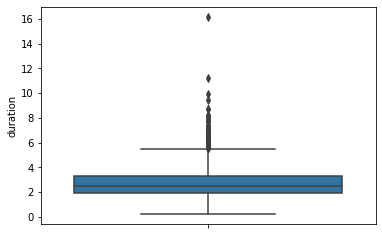

In [ ]:
# Using the average value based on the duration of the sound 
print('Mean : {:.3f}'.format(data_df.duration.mean()))
print('Median : {:.3f}'.format(data_df.duration.median()))
sns.boxplot(y=data_df.duration)
plt.show()

#### Processing Audio Files

In [ ]:
!mkdir processed_audio_1
#!mkdir processed_audio_Crackles
#!mkdir processed_audio_notCrackles

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    '''
    
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
def preprocessing_audio(data, path):
    i, c = 0,0
    temp_list = []
    for index,row in data.iterrows():
        maxLen=2.7
        Label = row['crackles']
        id = row['Id']
        start=row['start']
        end=row['end']
        filename=row['filename']
        
        #If len > maxLen , change it to maxLen
        if end-start>maxLen:
            end=start+maxLen
        audio_file_loc=path + filename + '.wav'

        if index > 0:
            # check if more cycles exits for same patient if so then add i to change filename
            if data.iloc[index-1]['filename'] == filename:
                i+=1
            else:
                i=0
        filename = filename + '_' + str(i) + '.wav'
        temp_list.append([id,filename,Label])    # Add to List
        save_path = '/content/processed_audio_1/' + filename    # Saving audio
        c+=1
        
        audioArr, sampleRate = lb.load(audio_file_loc)
        pureSample = getPureSample(audioArr, start, end, sampleRate)
        
        #pad audio if pureSample len < max_len
        reqLen = 6*sampleRate
        padded_data = lb.util.pad_center(pureSample, reqLen)    # zero-pad
        
        sf.write(file=save_path, data=padded_data, samplerate=sampleRate)
    
    lol = pd.DataFrame(temp_list)
    lol.columns = ['Id', 'File_Audio', 'Label']
    return lol
    print('Total Files Processed: ',c)

In [ ]:
# data for crackles label
start = time.perf_counter()
path = '/content/dataset/'
dataPrep_df = preprocessing_audio(data_df, path)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 4847.509 seconds.


In [ ]:
!zip -r /content/processed_audio_1.zip /content/processed_audio_1

from google.colab import files
files.download("/content/processed_audio_1.zip")

Streaming output truncated to the last 5000 lines.
  adding: content/processed_audio_1/224_1b1_Tc_sc_Meditron_6.wav (deflated 76%)
  adding: content/processed_audio_1/145_2b2_Lr_mc_AKGC417L_1.wav (deflated 64%)
  adding: content/processed_audio_1/186_3b3_Pr_mc_AKGC417L_4.wav (deflated 58%)
  adding: content/processed_audio_1/149_1b1_Al_sc_Meditron_0.wav (deflated 88%)
  adding: content/processed_audio_1/184_1b1_Ar_sc_Meditron_7.wav (deflated 73%)
  adding: content/processed_audio_1/130_1p4_Tc_mc_AKGC417L_0.wav (deflated 61%)
  adding: content/processed_audio_1/130_1p4_Ar_mc_AKGC417L_0.wav (deflated 60%)
  adding: content/processed_audio_1/186_2b2_Lr_mc_AKGC417L_4.wav (deflated 79%)
  adding: content/processed_audio_1/218_1b1_Al_sc_Meditron_4.wav (deflated 57%)
  adding: content/processed_audio_1/130_2b2_Ar_mc_AKGC417L_2.wav (deflated 62%)
  adding: content/processed_audio_1/154_3b3_Al_mc_AKGC417L_2.wav (deflated 59%)
  adding: content/processed_audio_1/188_1b1_Pl_sc_Meditron_2.wav (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataPrep_df.drop_duplicates(inplace=True)
dataPrep_df.tail()

,Id,File_Audio,Label
5501,226,226_1b1_Pl_sc_LittC2SE_1.wav,0
5502,226,226_1b1_Pl_sc_LittC2SE_2.wav,0
5503,226,226_1b1_Pl_sc_LittC2SE_3.wav,0
5504,226,226_1b1_Pl_sc_LittC2SE_4.wav,0
5505,226,226_1b1_Pl_sc_LittC2SE_5.wav,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


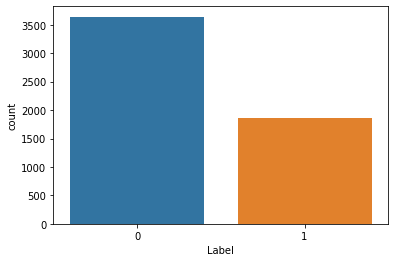

In [ ]:
sns.countplot(dataPrep_df.Label)
#plt.xticks(rotation=90)

In [ ]:
dataPrep_df.to_csv('dataPrep_df.csv', index=False)

### Feature Extraction

In [ ]:
dataPrep_df = pd.read_csv('/content/drive/MyDrive/Dataset/crackles_dataset/dataPrep_df.csv')
dataPrep_df.tail()

,Id,File_Audio,Label
5501,226,226_1b1_Pl_sc_LittC2SE_1.wav,0
5502,226,226_1b1_Pl_sc_LittC2SE_2.wav,0
5503,226,226_1b1_Pl_sc_LittC2SE_3.wav,0
5504,226,226_1b1_Pl_sc_LittC2SE_4.wav,0
5505,226,226_1b1_Pl_sc_LittC2SE_5.wav,0


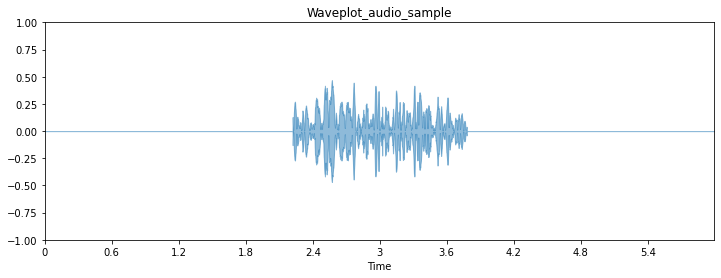

In [ ]:
# Plotting
random_num = np.random.randint(0,5505)
sample_audio = dataPrep_df.File_Audio.loc[random_num]
root = '/content/processed_audio_files/content/processed_audio_1/'
path = root+sample_audio

plt.figure(figsize=(12,4))
audio_arr, sr = lb.load(path)
lb.display.waveplot(audio_arr, alpha=0.5)
plt.ylim(-1,1)
plt.title('Waveplot_audio_sample')
plt.show()

In [ ]:
def features_extraction(path):
    soundArr,sample_rate = lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate, n_mfcc=20)
    return mfcc

In [ ]:
root='/content/processed_audio_files/content/processed_audio_1/'
feature_list = []
for idx,row in dataPrep_df.iterrows():
    path = root + row['File_Audio']
    fe = features_extraction(path)
    feature_list.append(fe)
    
feature_list = np.array(feature_list)
feature_label = np.array(dataPrep_df.Label, np.int)

print(feature_list.shape)
print(feature_label.shape)

(5506, 20, 259)
(5506,)


In [ ]:
print(feature_list[0])

[[-687.64685 -687.64685 -687.64685 ... -687.64685 -687.64685 -687.64685]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 ...
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]]


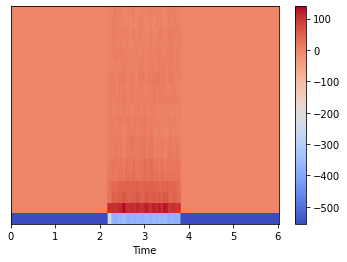

<Figure size 720x360 with 0 Axes>

In [ ]:
# Plotting mfcc
fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
img = librosa.display.specshow(feature_list[random_num], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
#.set(title='MFCC')

### Model

In [ ]:
feature_list_flatten = feature_list.reshape(feature_list.shape[0], 
                                            (feature_list.shape[1]*feature_list.shape[2]))
print(feature_list_flatten.shape)

(5506, 5180)


In [ ]:
# In the following plot we can see that classes are imbalanced so we must split 
# them into train and validation set via stratify

x_train, x_test, y_train, y_test = train_test_split(feature_list_flatten, feature_label, 
                                                    test_size=.2, 
                                                    stratify=feature_label, 
                                                    random_state=0)

print(x_train.shape)
print(x_test.shape)

(4404, 5180)
(1102, 5180)


#### Adaboost Classifier

In [ ]:
### Hyperparameter using GridSearchCv

start = time.perf_counter()
params_grid = dict(criterion=['gini','entropy'], 
                   max_depth=[3,4,5,6,7,8,9], 
                   min_samples_leaf=[5, 10, 20, 50, 100]) 

dt = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
grid_search = GridSearchCV(dt, param_grid=params_grid,
                           cv=cv, n_jobs=-1, verbose=10)

grid_search.fit(x_train, y_train)
#result = pd.DataFrame(grid_search_SVC.cv_results_)
elapsed = time.perf_counter() - start

print('Best score: {:.2f}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Elapsed %.3f seconds.' % elapsed)

In [ ]:
### Model

start = time.perf_counter()
dt = DecisionTreeClassifier()

# Validation
#cv = StratifiedKFold(n_splits=10)
#validation = cross_val_score(adaboost, x_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Training
dt.fit(x_train, y_train)
y_pred_test = dt.predict(x_test)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 13.318 seconds.


In [ ]:
#print('Accuracy_Val : {:.4f}\n'.format(validation.mean()))

print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
target_names = ['notCrackles','crackles']
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test, 
                                                                  target_names=target_names))

#print('\nPR-AUC crackles class: %.3f' % auc_score_kNN)
print('Elapsed %.3f seconds.' % elapsed)

Accuracy_test : 0.6044 Precision_test : 0.5547 Recall_test : 0.5537 F1-Score : 0.5541

classification report testing : 
               precision    recall  f1-score   support

 notCrackles       0.70      0.71      0.70       729
    crackles       0.41      0.40      0.40       373

    accuracy                           0.60      1102
   macro avg       0.55      0.55      0.55      1102
weighted avg       0.60      0.60      0.60      1102

Elapsed 13.318 seconds.


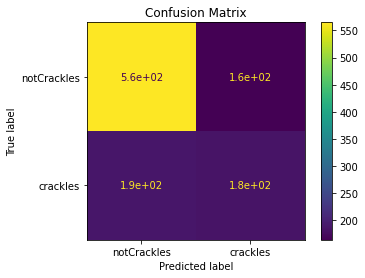

In [ ]:
# Plotting confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot = plot_confusion_matrix(adaboost, x_test, y_test, 
                             display_labels=['notCrackles','crackles'])
plot.ax_.set_title('Confusion Matrix')
plt.show()